In [7]:
import numpy as np
from matplotlib import pyplot as plt
from SEM import SEM
import seaborn as sns

In [8]:
# To model the single trial version of SEM, remove context by setting decay to 1, and only allow for the 
# the storage of 12 tokens 
single_trial_SEM = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.08, 'G_p':0.0, 'R_s': 0.5, 
                        'R_p': 0.20, 'T_o': 0.2, 'E_c': 1, 'E_l': 1.0, 'C_p':0, 'C_d': 0, 
                        'C_r': 0, 'C_i':0, 'C_a':0, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':6, 'max_tokens':6, 
                        'omission_val':-1, 'list_length':6, 'single_trial': True, 'saveFolder': 'SEM_figures/'}

multi_trial_SEM_dem5 = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.08, 'G_p':0.0, 'R_s': 0.5, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 1.0, 'C_p':1, 'C_d': 0, 
                        'C_r': 1, 'C_i':0, 'C_a':20, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':12, 'max_tokens': 30, 
                        'omission_val':-1, 'list_length':6, 'single_trial':False, 'saveFolder': 'SEM_figures/'}

multi_trial_SEM_dem6 = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.06, 'G_p':0.14, 'R_s': 0.5, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 1.0, 'C_p':1, 'C_d': 0, 
                        'C_r': 1, 'C_i':0, 'C_a':20, 'A_p': 1,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':12, 'max_tokens': 30, 
                        'omission_val':-1, 'list_length':6, 'single_trial':False, 'saveFolder': 'SEM_figures/'}

In [9]:
SEM_model = SEM(multi_trial_SEM_dem5)

In [12]:
num_trials = 10000
SEM_model.simulate_trials_SEM(num_trials=num_trials)

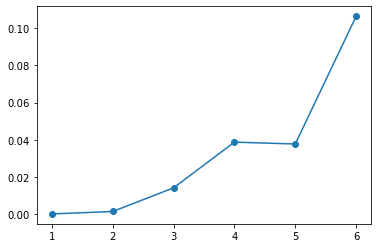

In [13]:
plt.plot([1,2,3,4,5,6], SEM_model.immediate_intrusions/num_trials, marker='o')

In [17]:
np.sum(np.round(SEM_model.immediate_intrusions/num_trials, 2))

0.2

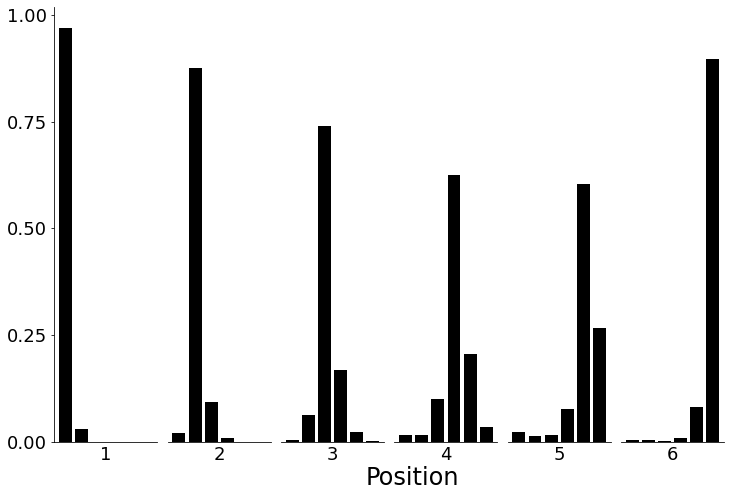

In [18]:
SEM_model.plot_transposition_gradient(save_name='Transpositions_single_trial_SEM')

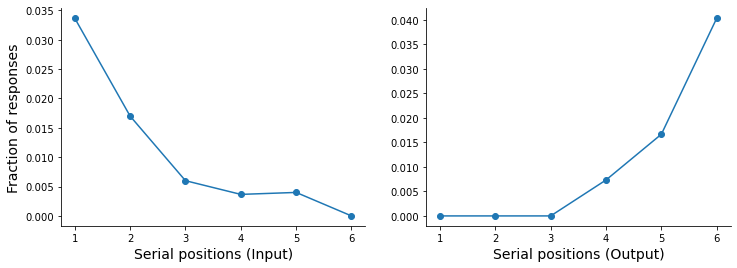

In [34]:
SEM_model.plot_errors_inp_out('rep', True, save_name='Repetitions_single_trial_SEM_02_omissions')

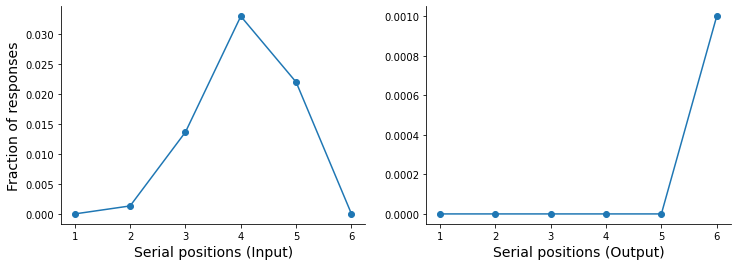

In [35]:
SEM_model.plot_errors_inp_out('omi', True, save_name='Omissions_02_SEM')